# Theano version of positive/negative samples

In [1]:
import theano.tensor as T
import theano
import numpy as np
from collections import OrderedDict
import negsamp
import sys
import matplotlib.pylab as plt
from progressbar import ProgressBar as pb 
%matplotlib inline

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 4007)


### Parameter specification

In [2]:
# Params
d = 100
f = 4096
hidden = 4096
V = 291
m=10

numlayers = 2
lr = 0.01
epochs = 100
batchsize=256
weightfile = None # 'params-2layer.npz'
pretrain = False

### Data ingestion. Currently just read in numpy files.

In [3]:
data = np.load('data/iaprtc_alexfc7.npz')
D = open('data/iaprtc_dictionary.txt').read().splitlines()
train_ims = [ im.split('/')[-1] for im in open('data/iaprtc_trainlist.txt').read().splitlines() ]
test_ims = [ im.split('/')[-1] for im in open('data/iaprtc_testlist.txt').read().splitlines() ]
xTr = data['xTr'].T
yTr = data['yTr'].T
xTe = data['xTe'].T
yTe = data['yTe'].T
wc = yTr.sum(axis=0)+0.01-0.01

### Load in parameters/weights

In [4]:
if weightfile and pretrain:
    Wi = theano.shared(np.load(weightfile)['Wi'])
    Wh = theano.shared(np.random.ranf((hidden, f)))
    Wc = theano.shared(np.load(weightfile)['Wc'])
elif weightfile:
    Wi = theano.shared(np.load(weightfile)['Wi'])
    Wh = theano.shared(np.load(weightfile)['Wh'])
    Wc = theano.shared(np.load(weightfile)['Wc'])
else:
    Wh = theano.shared(np.random.ranf((hidden, f)))
    Wi = theano.shared(np.random.ranf((d, hidden)))
    Wc = theano.shared(np.random.ranf((V, d)))

In [21]:
# Negative sampler
ns = negsamp.NegativeSampler(wc / wc.sum())

# Define functionality
x = T.matrix()
p = T.matrix()
n = T.matrix()

# Cross correlation
if numlayers==1:
    xcorr = Wc.dot(Wi.dot(x.T))
else:
    xcorr = Wc.dot(Wi.dot(T.nnet.sigmoid(Wh.dot(x.T))))

# Intuitive that these are the same
# loss = -T.log(T.nnet.sigmoid(p.dot(xcorr))).mean() - T.log(T.nnet.sigmoid(-n.dot(xcorr))).mean()
# loss = -T.log(T.nnet.sigmoid( (p-n).dot(xcorr)  )).mean()
loss = (n-p).dot( T.log( T.nnet.sigmoid(xcorr) ) ).mean()

# Define the gradient updates. Use positive for maximization
if numlayers==1:
    params = [Wi, Wc]
    gWi, gWc = T.grad(loss, params)
    sgd = OrderedDict( { Wi: Wi - lr*gWi, Wc: Wc - lr*gWc } )
else:
    params = [Wi, Wc, Wh]
    gWi, gWc, gWh = T.grad(loss, params)
    sgd = OrderedDict( { Wi: Wi - lr*gWi, Wc: Wc - lr*gWc, Wh: Wh - lr*gWh } )

# Compile to theano functionality
train = theano.function( [x,p,n], outputs=loss, updates=sgd, allow_input_downcast=True )

In [ ]:
p = pb(len(yTr))

# Iterate through the data size
for j in xrange(epochs):
    print "Epoch "+str(j)
    k=0
    totloss = 0.0
    batloss = 0.0
    randorder = np.random.permutation(len(yTr))
    for i in range(0,len(randorder),batchsize):
        
        indata = xTr[i:i+batchsize]
        outdata= yTr[i:i+batchsize]

        lossval = train( indata, outdata, ns.negsampv(outdata, m) )
        totloss += lossval
        batloss += lossval

        k+=1
        if k % 16 == 0:
            p.animate(k*batchsize)
            print('\nlosses (inst, bat, tot)=({},{},{})'.format(lossval, batloss, totloss))
            
    print ""
    print "Total loss on epoch "+str(j)+" = "+str(totloss)
    
    if numlayers==1:
        np.savez('params-ix.npz', Wi=Wi.get_value(), Wc=Wc.get_value(), Epoch=j)      
    else:
        np.savez('params-ix.npz', Wi=Wi.get_value(), Wh=Wh.get_value(), Wc=Wc.get_value(), Epoch=j)      


Epoch 0


### Save the arrays to parameter files

In [ ]:
if numlayers==1:
    np.savez('params-ix.npz', Wi=Wi.get_value(), Wc=Wc.get_value(), Epoch=j)      
else:
    np.savez('params-ix.npz', Wi=Wi.get_value(), Wh=Wh.get_value(), Wc=Wc.get_value(), Epoch=j)      

# Numpy verification and debugging

### Get the parameters from the GPU arrrays

<Container object of 3 artists>

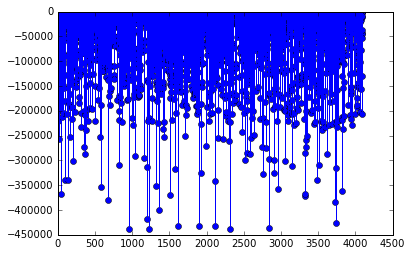

In [26]:
W0 = Wh.get_value()
W1 = Wi.get_value()
W2 = Wc.get_value()
plt.stem(W0.dot(xTe[40]))

#W0.dot(xTe[0:10].T)
#plt.imshow(W0); 
#plt.colorbar()